## Predicting the number of taxi orders for the next hour

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. We will build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

# 1. Preparation

In [ ]:
import pandas as pd
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0],  parse_dates=[0])

In [ ]:
print(df.index.is_monotonic)

True


In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [ ]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


`/datasets/taxi.csv` was opened and no null values were found. The dates and times were checked to see if they were in chronological order, and the data was resampled by one hour.

# 2. Analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae52ff7390>]],
      dtype=object)

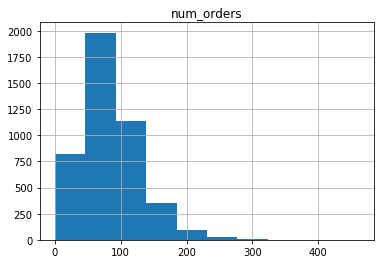

In [ ]:
df.hist()

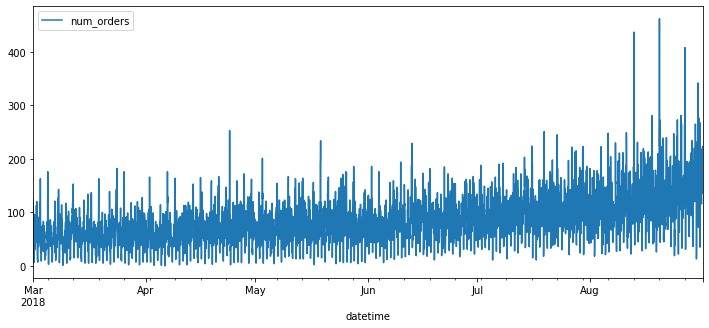

In [ ]:
df.plot(figsize=(12, 5))

Based on these initial graphs, it appears that the number of rides is increasing over time. There also looks like there may be specific times of day where the number of orders peak compared to the daily average. Further nvestigation will be done by grouping the data by `hour`, `day`, `dayofweek`, and `month`.

In [ ]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

Text(0, 0.5, 'Orders (mean)')

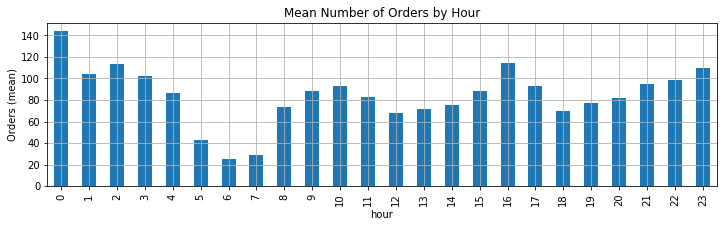

In [ ]:
df.groupby('hour')['num_orders'].mean().plot(kind='bar', figsize=(12, 3), grid=True, title='Mean Number of Orders by Hour').set_ylabel('Orders (mean)')

Text(0, 0.5, 'Orders (mean)')

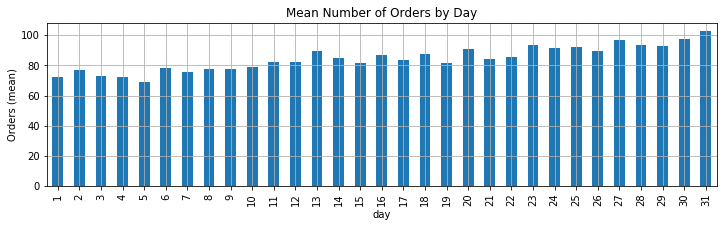

In [ ]:
df.groupby('day')['num_orders'].mean().plot(kind='bar', figsize=(12, 3), grid=True, title='Mean Number of Orders by Day').set_ylabel('Orders (mean)')

Text(0, 0.5, 'Orders (mean)')

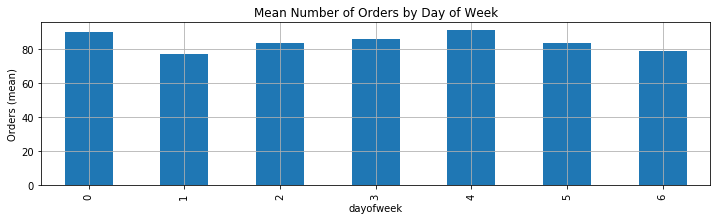

In [ ]:
df.groupby('dayofweek')['num_orders'].mean().plot(kind='bar', figsize=(12, 3), grid=True, title='Mean Number of Orders by Day of Week').set_ylabel('Orders (mean)')

Text(0, 0.5, 'Orders (mean)')

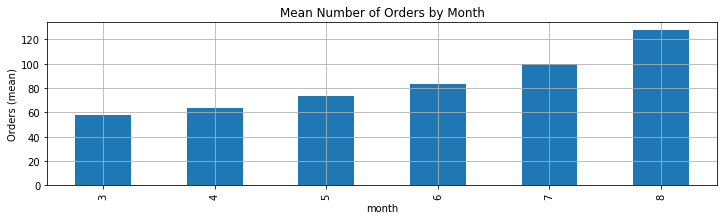

In [ ]:
df.groupby('month')['num_orders'].mean().plot(kind='bar', figsize=(12, 3), grid=True, title='Mean Number of Orders by Month').set_ylabel('Orders (mean)')

Hour of day has a large influence on the number of orders. The orders have a visible increase per month.

Day of week does not have as much of an influence on the number of orders. The number of orders also increase a little as each day of the month passes.

Next, the seasonality of the data will be explored.

Text(0, 0.5, 'Orders (mean)')

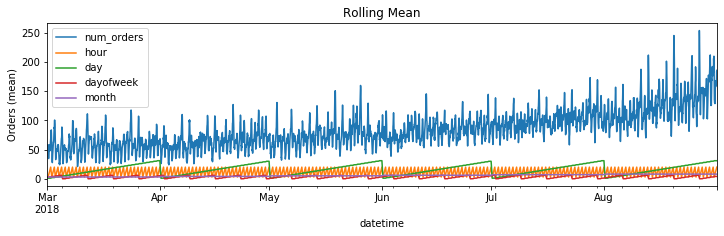

In [ ]:
df.rolling(7).mean().plot(figsize=(12, 3), title='Rolling Mean').set_ylabel('Orders (mean)')

In [ ]:
decomposed = seasonal_decompose(df['num_orders'])

Text(0, 0.5, 'Orders (mean)')

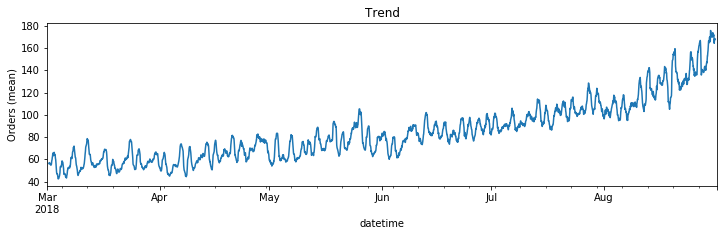

In [ ]:
decomposed.trend.plot(ax=plt.gca(), figsize=(12, 3), title='Trend').set_ylabel('Orders (mean)')

Text(0, 0.5, 'Orders (mean)')

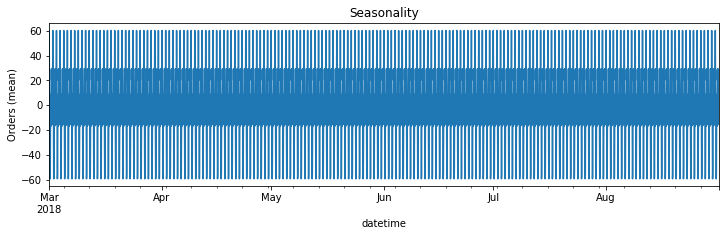

In [ ]:
decomposed.seasonal.plot(ax=plt.gca(), figsize=(12, 3), title='Seasonality').set_ylabel('Orders (mean)')

Text(0, 0.5, 'Orders (mean)')

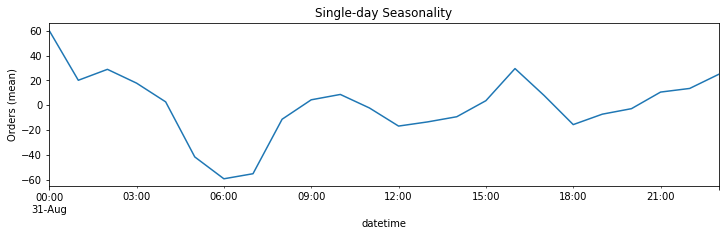

In [ ]:
decomposed.seasonal['2018-08-31'].plot(figsize=(12, 3), title='Single-day Seasonality').set_ylabel('Orders (mean)')

Text(0, 0.5, 'Orders (mean)')

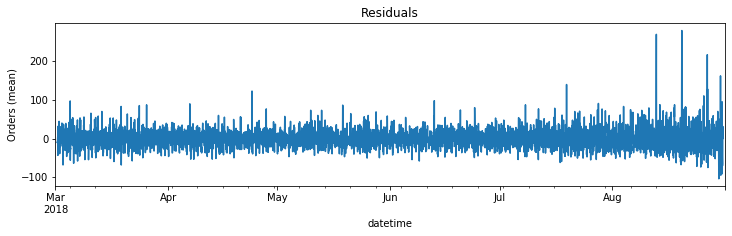

In [ ]:
decomposed.resid.plot(ax=plt.gca(), figsize=(12, 3), title='Residuals').set_ylabel('Orders (mean)')

After analyzing the seasonality graphs, three peaks in orders generally occur throughout each day: 
- midnight
- the start of the work day
- at the end of the work day

It is lowest in the morning, at 6AM. Taxi usage has increased through the months.

# 3. Training

In [ ]:
def make_features(data, max_lag, rolling_mean_size):    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
make_features(df, 7, 7)

In [ ]:
train_valid, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [ ]:
train = train.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)

target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1) 

In [ ]:
print("--- Train Sizes (Rows, Columns) ---")
print("target_train:", target_train.shape)
print("features_train:", features_train.shape)
print("")
print("--- Valid Sizes (Rows, Columns) ---")
print("target_test:", target_valid.shape)
print("features_test:", features_valid.shape)
print("")
print("--- Test Sizes (Rows, Columns) ---")
print("target_test:", target_test.shape)
print("features_test:", features_test.shape)

--- Train Sizes (Rows, Columns) ---
target_train: (3569,)
features_train: (3569, 12)

--- Valid Sizes (Rows, Columns) ---
target_test: (398,)
features_test: (398, 12)

--- Test Sizes (Rows, Columns) ---
target_test: (442,)
features_test: (442, 12)


### Comparing models with default hyperparameters

#### Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predicted_train = lr_model.predict(features_train)
predicted_valid = lr_model.predict(features_valid)

print("Training RMSE:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("Valid RMSE:", mean_squared_error(target_valid, predicted_valid) ** 0.5)

Training RMSE: 29.09181495407143
Valid RMSE: 40.64851246098521


#### Decision Tree Regressor

In [ ]:
dt_model = DecisionTreeRegressor(random_state=99)
dt_model.fit(features_train, target_train)
predicted_train = dt_model.predict(features_train)
predicted_valid = dt_model.predict(features_valid)

print("Training RMSE:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("Valid RMSE:", mean_squared_error(target_valid, predicted_valid) ** 0.5)

Training RMSE: 0.0
Valid RMSE: 39.30076654794765


#### Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor(random_state=99, n_estimators=10)
rf_model.fit(features_train, target_train)
predicted_train = rf_model.predict(features_train)
predicted_valid = rf_model.predict(features_valid)

print("Training RMSE:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("Valid RMSE:", mean_squared_error(target_valid, predicted_valid) ** 0.5)

Training RMSE: 9.562091112239957
Valid RMSE: 33.303136028709574


#### LightGBM Regressor

In [ ]:
lg_model = lgb.LGBMRegressor(random_state=99)
lg_model.fit(features_train, target_train)
predicted_train = lg_model.predict(features_train)
predicted_valid = lg_model.predict(features_valid)

print("Training RMSE:", mean_squared_error(target_train, predicted_train) ** 0.5)
print("Valid RMSE:", mean_squared_error(target_valid, predicted_valid) ** 0.5)

Training RMSE: 13.290113613835565
Valid RMSE: 32.53164203499691


LightGBM Regressor produced the lowest RMSE out of the four models with default hyperparameters.

#### Tuning LightGBM

In [ ]:
for num in range(15, 35, 5):
    tuned_lg_model = lgb.LGBMRegressor(random_state=99, n_estimators=num)
    tuned_lg_model.fit(features_train, target_train)
    predicted_train = tuned_lg_model.predict(features_train)
    predicted_valid = tuned_lg_model.predict(features_valid)

    print('----', num, '----')
    print("Training RMSE:", mean_squared_error(target_train, predicted_train) ** 0.5)
    print("Valid RMSE:", mean_squared_error(target_valid, predicted_valid) ** 0.5)
    print("")

---- 15 ----
Training RMSE: 21.37806756483685
Valid RMSE: 37.31212774408887

---- 20 ----
Training RMSE: 19.815866243676897
Valid RMSE: 35.11446715889318

---- 25 ----
Training RMSE: 18.89705440412415
Valid RMSE: 33.91972650746149

---- 30 ----
Training RMSE: 18.215826625837735
Valid RMSE: 33.38919039164698



The best `n_estimtors` hyperparameter for LightGBM here is 30.

# 4. Testing

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state=12345)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders'] 

In [ ]:
final_lg_model = lgb.LGBMRegressor(random_state=99, n_estimators=30)
final_lg_model.fit(features_train, target_train)
predicted_test = final_lg_model.predict(features_test)

print("Test RMSE:", mean_squared_error(target_test, predicted_test) ** 0.5)

Test RMSE: 46.78990642041463


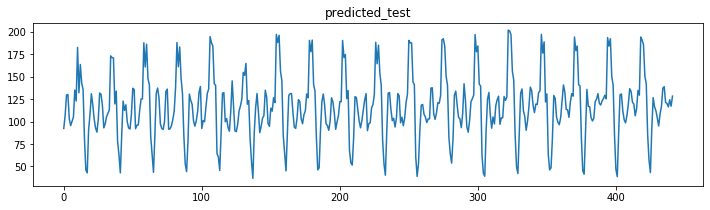

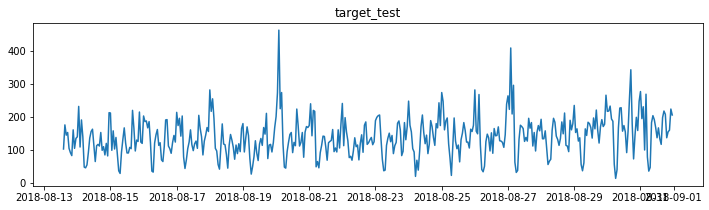

In [ ]:
plt.figure(figsize=(12, 3))
plt.title('predicted_test')
plt.plot(predicted_test)
plt.show()

plt.figure(figsize=(12, 3))
plt.title('target_test')
plt.plot(target_test)
plt.show()

The final RMSE from the LightGBM model is 46.79. A few sharp peaks remain on `target_test`, which can be improved on with further tuning.